In [1]:
from Main.framework import Value
from Main.neuralnet import Neuron, Layer, MLP
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
np.random.seed(1337)
random.seed(1337)

In [2]:
# Generate a dataset
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise=0.3)

In [3]:
X

array([[ 1.88943909,  0.7519102 ],
       [ 0.92409193,  0.70870937],
       [ 0.8219274 ,  0.02050232],
       ...,
       [ 2.04270255, -0.52387199],
       [ 0.36031997,  0.15989308],
       [ 0.63162872,  0.54265882]])

In [4]:
y

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,

In [5]:
y = np.array([2*i-1 for i in y])  # Convert y to be -1 or 1
y

array([ 1, -1, -1,  1,  1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  1,  1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1,  1,  1,  1,  1,
       -1,  1, -1, -1, -1,  1,  1,  1, -1, -1, -1,  1,  1,  1, -1,  1, -1,
        1, -1, -1,  1,  1, -1,  1,  1,  1, -1,  1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  1,  1, -1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1,  1,
        1, -1,  1,  1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1, -1, -1, -1,
        1,  1, -1,  1, -1, -1, -1, -1,  1, -1, -1,  1, -1, -1,  1, -1, -1,
       -1, -1,  1,  1, -1,  1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  1, -1,
        1,  1, -1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1,  1, -1,  1, -1,
        1,  1,  1,  1, -1, -1, -1, -1,  1, -1, -1, -1,  1,  1, -1,  1,  1,
       -1, -1, -1,  1,  1,  1, -1, -1,  1,  1, -1,  1,  1,  1,  1, -1, -1,
        1, -1,  1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1,  1,  1, -1,
       -1, -1,  1, -1,  1,  1, -1, -1, -1,  1, -1,  1,  1, -1, -1, -1,  1,
       -1, -1, -1, -1, -1

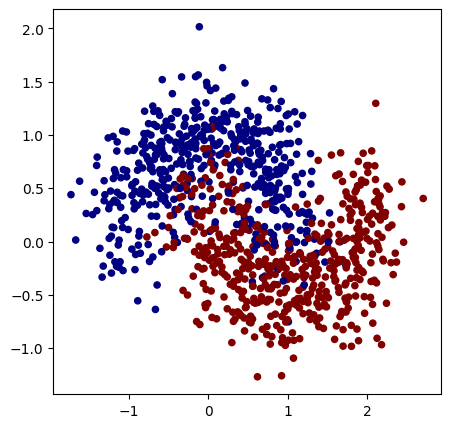

In [6]:
# Visualize in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='jet')

In [7]:
# Initialize a model
model = MLP(2, [18, 18, 1])  # 2-layer neural network
print(model)
print("Number of parameters:", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(18), ReLUNeuron(18), ReLUNeuron(18), ReLUNeuron(18), ReLUNeuron(18), ReLUNeuron(18), ReLUNeuron(18), ReLUNeuron(18), ReLUNeuron(18), ReLUNeuron(18), ReLUNeuron(18), ReLUNeuron(18), ReLUNeuron(18), ReLUNeuron(18), ReLUNeuron(18), ReLUNeuron(18), ReLUNeuron(18), ReLUNeuron(18)], Layer of [LinearNeuron(18)]]
Number of parameters: 415


In [8]:
# Define loss function
def loss(batch_size=None):
    # Inline DataLoader
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]

    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # Forward the model to get scores
    scores = list(map(model, inputs))

    # SVM "max-margin" loss
    losses = [(1 + -yi * scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))

    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p * p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # Calculate accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)


In [9]:
# Calculate initial loss and accuracy
total_loss, acc = loss()
print(f"Initial loss: {total_loss.data:.4f}, accuracy: {acc * 100:.2f}%")

Initial loss: 2.5063, accuracy: 30.10%


In [10]:
# Initialize DataFrame to store optimization details
optimization_details = pd.DataFrame(columns=['Loss', 'Accuracy'])
# Optimization loop
for k in range(100):
    # Forward
    total_loss, acc = loss(32) # Adjust batch size based on sample and memory constraints

    # Backward
    model.zero_grad()
    total_loss.backward()

    # Update (SGD)
    learning_rate = 1.0 - 0.9 * k / 100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    # Store details in DataFrame
    optimization_details.loc[len(optimization_details.index)] = { 'Loss': total_loss.data, 'Accuracy': acc * 100}
optimization_details.index += 1

In [11]:
optimization_details.head()

,Loss,Accuracy
1,2.334550,37.500
2,1.223966,43.750
3,0.972610,59.375
4,0.526633,81.250
5,0.532325,78.125


In [12]:
optimization_details.tail()

,Loss,Accuracy
96,0.173243,90.625
97,0.301894,87.500
98,0.280841,90.625
99,0.151970,93.750
100,0.257654,90.625


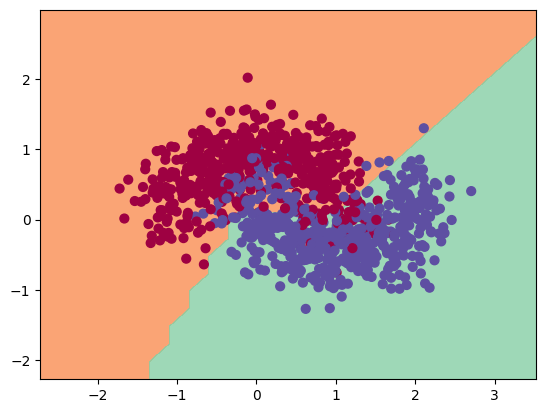

In [13]:
# Visualize decision boundary
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]

inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

In [16]:
# Training data
y_pred_train = [1 if model([Value(xi[0]), Value(xi[1])]).data > 0 else -1 for xi in X]

# New data for testing
Xtest, ytest = make_moons(n_samples=1000, noise=0.3)
ytest = np.array([2*i-1 for i in ytest])  # Convert y to be -1 or 1
y_pred_test = [1 if model([Value(xi[0]), Value(xi[1])]).data > 0 else -1 for xi in Xtest]

Training Data: Precision = 89.21%, Recall = 86.00%, F1 Score = 0.88
Test Data: Precision = 90.23%, Recall = 85.00%, F1 Score =0.88


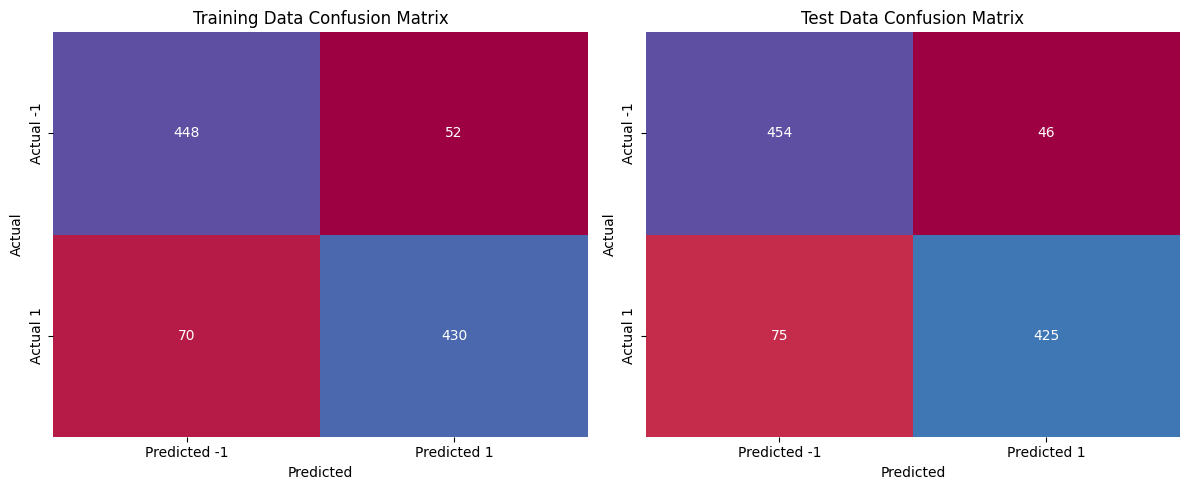

In [17]:
def plot_matrix(y_true, y_pred, title, ax):
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Spectral', cbar=False,
                xticklabels=['Predicted -1', 'Predicted 1'], yticklabels=['Actual -1', 'Actual 1'], ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{title} Confusion Matrix')

def plot_metrics(y_train, y_pred_train, y_test, y_pred_test):
    # Calculate metrics for training data
    precision_train = precision_score(y_train, y_pred_train)*100
    recall_train = recall_score(y_train, y_pred_train)*100
    f1_train = f1_score(y_train, y_pred_train)
    
    # Calculate metrics for test data
    precision_test = precision_score(y_test, y_pred_test)*100
    recall_test = recall_score(y_test, y_pred_test)*100
    f1_test = f1_score(y_test, y_pred_test)
    
    # Print metrics
    print(f'Training Data: Precision = {precision_train:.2f}%, Recall = {recall_train:.2f}%, F1 Score = {f1_train:.2f}')
    print(f'Test Data: Precision = {precision_test:.2f}%, Recall = {recall_test:.2f}%, F1 Score ={f1_test:.2f}')
    
    # Plot confusion matrices side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    plot_matrix(y_train, y_pred_train, "Training Data", axs[0])
    plot_matrix(y_test, y_pred_test, "Test Data", axs[1])

    plt.tight_layout()
    plt.show()

plot_metrics(y, y_pred_train, ytest, y_pred_test)
